# This Toolbox is used to process model output and compare model results with observations/reanalysis data
-----------------------------------------------------------------
$Observation:$ CERES
<br>
$Reanalysis:$ ERA5
<br>
$Model:$
<br>
    ==>SP: crm_nx = 32, crm_ny = 1, crm_nz = 125, dx = 1200m, dt = 5s 
<br>
    ==>UP: crm_nx = 64, crm_ny = 1, crm_nz = 125, dx = 200m,  dt = 0.5s
-----------------------------------------------------------------

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import xarray as xr
import netCDF4 as nc
from matplotlib import ticker, cm
from matplotlib import animation, rc
import matplotlib.tri as tri
import sys
#import metpy.calc as mpcalc
#from metpy.cbook import get_test_data
#from metpy.interpolate import cross_section
import scipy.ndimage as ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.setrecursionlimit(9000)
import scipy.ndimage
import statistics
import scipy.io
import seaborn as sns
import pandas as pd
from cartopy.util import add_cyclic_point
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import griddata

Check 2D model output
--------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# Change this part
sYear   = 2008
sMonth  = 10 
sDay    = 1
sHour   = 0
eYear   = 2008
eMonth  = 10
eDay    = 2
eHour   = 0
HisFlag = 'h2' # This output is for daily average
ndays   = eDay - sDay + 1
nyear = 1

In [3]:
#SP_PATH = '/media/liran/PLR5/UCI_results/SP/'
SP_PATH = '/scratch1/07088/tg863871/SPCTRL_ERA5_2008_rrtmgp_frontera_ne16pg2_r05_oQU240_CRM1_32x_120z2000m.5s_crm_nx_rad_16_np_768_nlev_125.frontera/run/'
SP2008 = xr.open_mfdataset(SP_PATH+'SPCTRL_ERA5_2008_rrtmgp_frontera_ne16pg2_r05_oQU240_CRM1_32x_120z2000m.1s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-0[0-2]-*.nc')
#UP_PATH = '/media/liran/PLR5/UCI_results/UP/'
UP_PATH = '/scratch1/07088/tg863871/UPCTRL_ERA5_2008_rrtmgp_frontera_ne16pg2_r05_oQU240_CRM1_64x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera/run/'
UP2008 = xr.open_mfdataset(UP_PATH+'UPCTRL_ERA5_2008_rrtmgp_frontera_ne16pg2_r05_oQU240_CRM1_64x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-0[0-2]-*.nc')

In [7]:
CERES_PATH = '/scratch1/07088/tg863871/CERES/'
count = 0
for iy in range(sYear,eYear+1,1):
    CERES_FAME = 'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_'+str(iy)+'1001-'+str(iy)+'1130.nc'
    CERES_FILE = nc.Dataset(CERES_PATH+CERES_FAME, mode = 'r')
    toa_sw_all_daily = CERES_FILE.variables['toa_sw_all_daily']
    toa_lw_all_daily = CERES_FILE.variables['toa_lw_all_daily']
    toa_solar_all_daily = CERES_FILE.variables['toa_solar_all_daily']
    if count ==0: 
        fsntoa_obs      = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
        toa_lw_obs      = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
    else:
        work1           = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
        work2           = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
        fsntoa_obs      = fsntoa_obs+work1
        toa_lw_obs      = toa_lw_obs+work2
    count           = count + 1
    print(count)
fsntoa_obs = fsntoa_obs/count
toa_lw_obs = toa_lw_obs/count
fsntoa_obs_mean = np.mean(fsntoa_obs, axis=0)
toa_lw_obs_mean = np.mean(toa_lw_obs, axis=0)
# Read coordinates
lon_CERES  = CERES_FILE.variables['lon'] # 360
lat_CERES  = CERES_FILE.variables['lat'] # 180
time_CERES = CERES_FILE.variables['time']

1


/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  # Remove the CWD from sys.path while we load stuff.
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  # Remove the CWD from sys.path while we load stuff.
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  # Remove the CWD from sys.path while we load stuff.
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  # Remove the CWD from sys.path while we load stuff.
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_min not used si

In [8]:
# ERA5 data  ---------------------------------------------------------------------------------------------------
# There are many 2D variables saved in ERA5 file. You can check others. Here I only read lcc and tclw 
ERA5_Ensemble2    = np.zeros([nyear,721,1440])
ERA5_Ensemblelwp2  = np.zeros([nyear,721,1440])
for iy in range(sYear,eYear+1,1):
    ERA5_Path = '/scratch1/07088/tg863871/ERA5/'+str(iy)+'/'
    ERA5_Ensemble    = np.zeros([ndays,721,1440])
    ERA5_Ensemblelwp = np.zeros([ndays,721,1440])
    for id in range(sDay,eDay+1,1):
        ERA5_files = xr.open_mfdataset(ERA5_Path+'ERA5_sfc_'+str(iy)+'10'+str(id).zfill(2)+'.nc')
        ERA5_hourly = ERA5_files.variables['lcc'] 
        ERA5_hourly2 = ERA5_files.variables['tclw']
        ERA5_Ensemble[id-sDay,:,:] = np.mean(ERA5_hourly, axis=0)
        ERA5_Ensemblelwp[id-sDay,:,:] = np.mean(ERA5_hourly2, axis=0)
    ERA5_Ensemble2[iy-sYear,:,:] = np.mean(ERA5_Ensemble, axis=0)
    ERA5_Ensemblelwp2[iy-sYear,:,:] = np.mean(ERA5_Ensemblelwp, axis=0)
ERA5_Ensemble_mean = np.mean(ERA5_Ensemble2, axis=0)
ERA5_Ensemblelwp_mean = np.mean(ERA5_Ensemblelwp, axis=0)

lon_ERA5  = ERA5_files.variables['longitude'] 
lat_ERA5  = ERA5_files.variables['latitude'] 
xi = lon_ERA5[:]
yi = lat_ERA5[:]
XiERA5, YiERA5 = np.meshgrid(lon_ERA5, lat_ERA5)

In [118]:
# Read CERES coordinates
lon = SP2008.lon.values
lat = SP2008.lat.values
points6 = np.zeros([6144, 2])
points6[:,0] = lon[1,:]
points6[:,1] = lat[1,:]
xi = lon_CERES[:]
yi = lat_CERES[:]
Xi, Yi = np.meshgrid(lon_CERES, lat_CERES)
UP_Ensemble    = np.zeros([nyear,6144])
SP_Ensemble    = np.zeros([nyear,6144])
UPhy_Ensemble  = np.zeros([nyear,6144])
SP2008_FSNTOA                 = SP2008.variables['FSNTOA'] 
UP2008_FSNTOA                 = UP2008.variables['FSNTOA'] 
UP_Ensemble[0,:] = np.mean(UP2008_FSNTOA[:,:], axis=0)
SP_Ensemble[0,:] = np.mean(SP2008_FSNTOA[:,:], axis=0)
UPFSNTOA_Ensemble_standard   = np.mean(UP_Ensemble, axis=0)
SPFSNTOA_Ensemble_standard   = np.mean(SP_Ensemble, axis=0)
UPFSNTOA_Ensemble_standardi  = griddata(points6,UPFSNTOA_Ensemble_standard[:], (Xi, Yi), method='nearest')
SPFSNTOA_Ensemble_standardi  = griddata(points6,SPFSNTOA_Ensemble_standard[:], (Xi, Yi), method='nearest')

/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases late

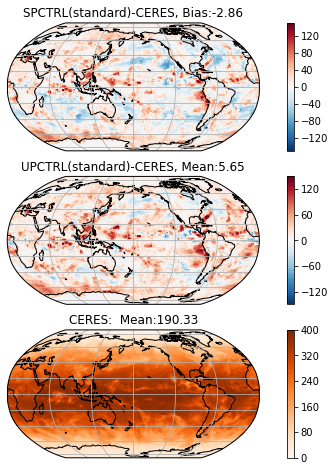

In [119]:
# Compare with FSNTOA
xi = lon_CERES[:]+180
yi = lat_CERES[:]
#-- create figure and axes object
fig = plt.figure(figsize=(10,8))
levels = np.linspace(0, 400, 81)
levels2 = np.linspace(-150.0, 150.0, 101)
levels3 = np.linspace(-80.0, 80.0, 101)
# --------------------
ax4 = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=180.0))
ax4.coastlines()
ax4.gridlines()
cntr4=ax4.contourf(xi, yi, SPFSNTOA_Ensemble_standardi-fsntoa_obs_mean, levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
cb4 = fig.colorbar(cntr4, ax=ax4)
tick_locator = ticker.MaxNLocator(nbins = 9)
cb4.locator = tick_locator
cb4.update_ticks()
title4 = 'SPCTRL(standard)-CERES, Bias:'+'{:.2f}'
ax4.set_title(title4.format(np.mean(SPFSNTOA_Ensemble_standardi-fsntoa_obs_mean)))
# --------------------
ax5 = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=180.0))
ax5.set_global()
#-- add coastlines, country border lines, and grid lines
ax5.coastlines()
ax5.gridlines()
cntr5=ax5.contourf(xi, yi, UPFSNTOA_Ensemble_standardi-fsntoa_obs_mean, levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
cb5 = fig.colorbar(cntr5, ax=ax5)
tick_locator = ticker.MaxNLocator(nbins = 5)
cb5.locator = tick_locator
cb5.update_ticks()
title5 = 'UPCTRL(standard)-CERES, Mean:'+'{:.2f}'
ax5.set_title(title5.format(np.mean(UPFSNTOA_Ensemble_standardi-fsntoa_obs_mean)))
# --------------------
ax8 = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=180.0))
ax8.coastlines()
ax8.gridlines()
cntr8=ax8.contourf(lon_CERES[:], lat_CERES[:], fsntoa_obs_mean, levels=levels, cmap="Oranges",transform=ccrs.PlateCarree())
cb8 = fig.colorbar(cntr8, ax=ax8)
tick_locator = ticker.MaxNLocator(nbins = 5)
cb8.locator = tick_locator
cb8.update_ticks()
title8 = 'CERES: '+' Mean:'+'{:.2f}'
ax8.set_title(title8.format(np.mean(fsntoa_obs_mean)))
plt.savefig('FSNTOA_20081001_20081002_CERES.png')
plt.show()

Check Single point profile
--------------------------------------------------------------------------------------------------------------------------------------

In [13]:
# Borneo
Center_lon = 114.5
Center_lat = 1.02  
# Congo
Center_lon = 21.94
Center_lat = -0.66 
# Amazon
#Center_lon = -65.55
#Center_lat = -4.37  

Time_stamp = 20 # The time index
# Read CERES coordinates
lon = np.squeeze(SP2008.lon.isel(time=Time_stamp).values)
lat = np.squeeze(SP2008.lat.isel(time=Time_stamp).values)

In [10]:
# Function calculate the distance between two points
def distance2(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [11]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

In [14]:
# Find the column index corresponds to the minimum distance
ddmin = 99999999.0
for icol in range(0,len(lon)-1):
    dd = distance2(lat[icol], lon[icol], Center_lat, Center_lon)
    if dd<ddmin:
        ddmin = dd
        indselect = icol

/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases late

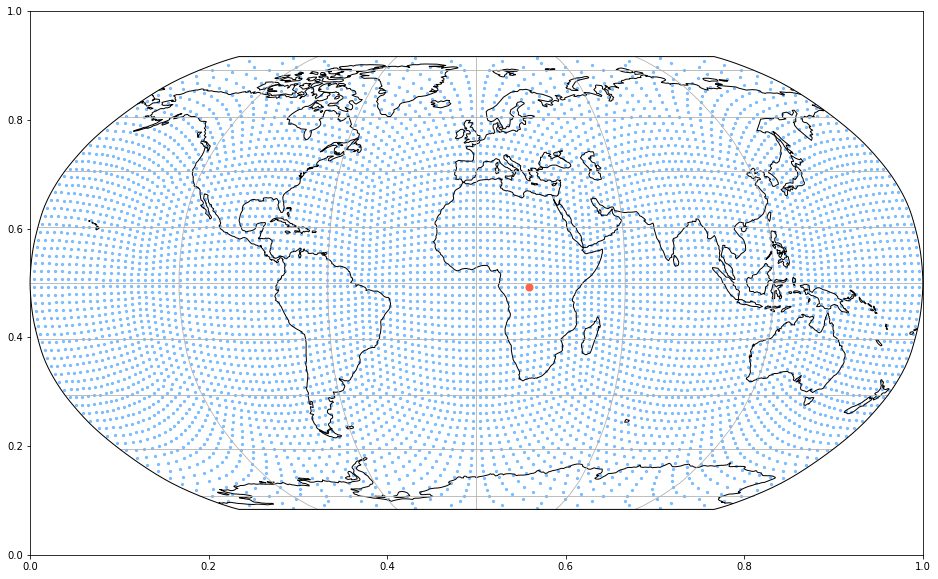

In [156]:
# Check the location of the selected point
#-- create figure and axes object
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()
plt.scatter(lon[:], lat[:],
            color="dodgerblue",
            s=5,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important
plt.scatter(lon[indselect], lat[indselect],
            color="tomato",
            s=50,
            alpha=1,
            transform=ccrs.PlateCarree()) ## Important
#plt.show()
plt.savefig('Single_Point_Borneo_Model.png')
#plt.savefig('Single_Point_Congo_Model.png')
#plt.savefig('Single_Point_Borneo_Model.png')

In [145]:
varname = "U"
evalstring2 = "np.squeeze(SP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
U1 = eval(evalstring2)
evalstring2 = "np.squeeze(UP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
U2 = eval(evalstring2)
varname = "V"
evalstring2 = "np.squeeze(SP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
V1 = eval(evalstring2)
evalstring2 = "np.squeeze(UP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
V2 = eval(evalstring2)
varname = "T"
evalstring2 = "np.squeeze(SP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
T1 = eval(evalstring2)
evalstring2 = "np.squeeze(UP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
T2 = eval(evalstring2)
varname = "SPWW"
evalstring2 = "np.squeeze(SP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
SPWW1 = eval(evalstring2)
evalstring2 = "np.squeeze(UP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
SPWW2 = eval(evalstring2)
varname = "CLOUD"
evalstring2 = "np.squeeze(SP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
CLD1 = eval(evalstring2)
evalstring2 = "np.squeeze(UP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
CLD2 = eval(evalstring2)
varname = "Z3"
evalstring2 = "np.squeeze(SP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
Z1 = eval(evalstring2)
evalstring2 = "np.squeeze(UP2008."+varname+".isel(ncol=indselect).isel(time=Time_stamp).values)"
Z2 = eval(evalstring2)

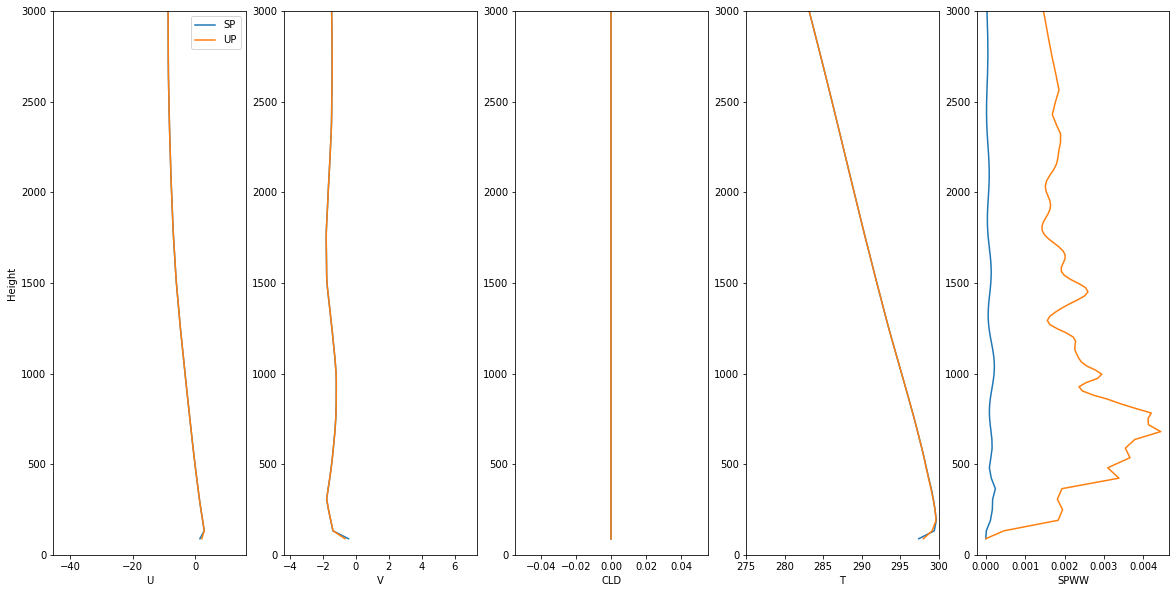

In [146]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
aax2, = ax1.plot(U1, Z1)
aax3, = ax1.plot(U2, Z2)
ax1.set_xlabel('U')
ax1.set_ylabel('Height')
aax2.set_label('SP')
aax3.set_label('UP')
ax1.set(ylim=(0, 3000))
ax1.legend()

_ = ax2.plot(V1, Z1)
_ = ax2.plot(V2, Z2)
ax2.set(ylim=(0, 3000))
ax2.set_xlabel('V')

_ = ax3.plot(CLD1, Z1)
_ = ax3.plot(CLD2, Z2)
ax3.set(ylim=(0, 3000))
ax3.set_xlabel('CLD')

_ = ax4.plot(T1, Z1)
_ = ax4.plot(T2, Z2)
ax4.set(xlim=(275, 300),ylim=(0, 3000))
ax4.set_xlabel('T')

_ = ax5.plot(SPWW1, Z1)
_ = ax5.plot(SPWW2, Z2)
ax5.set(ylim=(0, 3000))
ax5.set_xlabel('SPWW')

#plt.savefig('Model_Profile_SPUP_Compare_Borneo_Step'+str(it)+'.png')
#plt.savefig('Model_Profile_SPUP_Compare_Congo_Step'+str(it)+'.png')
plt.savefig('Model_Profile_SPUP_Compare_Amazon_Step'+str(it)+'.png')

Check Single point Height-Time plot
--------------------------------------------------------------------------------------------------------------------------------------

In [157]:
Start_Day = 0
End_Day = 2
Index_Start = (Start_Day)*144
Index_End = (End_Day)*144
num_Index = Index_End - Index_Start 
time = np.linspace(Start_Day, End_Day, num_Index)

In [158]:
SPWWSP  = SP2008.SPWW.values
SPWWUP  = UP2008.SPWW.values
CLOUDSP  = SP2008.CLOUD.values
CLOUDUP  = UP2008.CLOUD.values
cld_cross1 = np.transpose(CLOUDSP[Index_Start:Index_End,:,indselect])
cld_cross2 = np.transpose(CLOUDUP[Index_Start:Index_End,:,indselect])
ball_cross1 = np.transpose(SPWWSP[Index_Start:Index_End,:,indselect])
ball_cross2 = np.transpose(SPWWUP[Index_Start:Index_End,:,indselect])
Z31  = SP2008.Z3.values
Z3p1 = Z31[0,:,indselect]
Z3  = UP2008.Z3.values
Z3p = Z3[0,:,indselect]

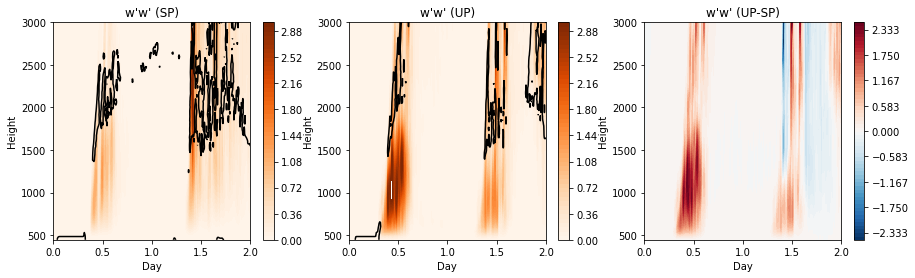

In [160]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
varname = ["w'w'"]
varmin = [0]
varmax = [3.0]
varmax1 = [0.05]
varinter = [51]
vardmin = [-2.5]
vardmax = [2.5]
vardinter = [61]

levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])
cf = ax1.contourf(time,Z3p1,ball_cross1,200, cmap="Oranges", levels=levels)
cf02 = ax1.contour(time,Z3p1,cld_cross1,200,colors='k', levels=[0.1], linestyles='-')
cb = fig.colorbar(cf, ax=ax1)
ax1.set( ylim=(min(Z3p), 3000))
titlestring = ("w'w' (SP)")
tx = ax1.set_title(titlestring)
ax1.set_xlabel('Day')
ax1.set_ylabel('Height')
cf2 = ax2.contourf(time,Z3p,ball_cross2,200, cmap="Oranges", levels=levels)
cf12 = ax2.contour(time,Z3p,cld_cross2,200,colors='k', levels=[0.1], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set( ylim=(min(Z3p), 3000))
titlestring2 = ("w'w' (UP)")
tx2 = ax2.set_title(titlestring2)
ax2.set_xlabel('Day')
ax2.set_ylabel('Height')

cf3 = ax3.contourf(time,Z3p,ball_cross2-ball_cross1,200, cmap="RdBu_r", levels=levels2)
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set( ylim=(min(Z3p), 3000))
titlestring3 = ("w'w' (UP-SP)")
tx3 = ax3.set_title(titlestring3)
ax3.set_xlabel('Day')
ax3.set_ylabel('Height')
plt.savefig('Cloud_SPWW_Time_Height_Borneo.eps')
#plt.savefig('Cloud_SPWW_Time_Height_Congo.eps')
#plt.savefig('Cloud_SPWW_Time_Height_Amazon.eps')

Check Crosssection plot
--------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# Borneo
Center_lon1 = 110.0  # <<<<< Red, Up left
Center_lat1 = 3.0  
Center_lon2 = 110.0  # <<<<< Blue Down Left
Center_lat2 = -3.0   

Center_lon3 = 117.0  # <<<<< Orange Up right
Center_lat3 = 3.0  
Center_lon4 = 117.0  # <<<<< Black Down right
Center_lat4 = -3.0   

Day_avg              = 2
Day_avg_start        = 0

In [5]:
# Here I use daily averaged output
SP2008d = xr.open_mfdataset(SP_PATH+'SPCTRL_ERA5_2008_rrtmgp_frontera_ne16pg2_r05_oQU240_CRM1_32x_120z2000m.1s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h2.2008-10-01-00000.nc')
UP2008d = xr.open_mfdataset(UP_PATH+'UPCTRL_ERA5_2008_rrtmgp_frontera_ne16pg2_r05_oQU240_CRM1_64x_120z200m.0.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h2.2008-10-01-00000.nc')

In [16]:
# This part is slow! Now we are using ERA5 grid. 
# Find the column index corresponds to the minimum distance
ddmin1 = 99999999.0
for il in range(len(lon_ERA5)):
    for ila in range(len(lat_ERA5)):
        dd = distance2(lat_ERA5[ila], lon_ERA5[il], Center_lat1, Center_lon1)
        if dd<ddmin1:
            ddmin1 = dd
            minindexlon1 = il
            minindexlat1 = ila
print(ddmin1,minindexlon1,minindexlat1)

0.0 440 348


In [17]:
# Find the column index corresponds to the minimum distance
ddmin1 = 99999999.0
for il in range(len(lon_ERA5)):
    for ila in range(len(lat_ERA5)):
        dd = distance2(lat_ERA5[ila], lon_ERA5[il], Center_lat2, Center_lon2)
        if dd<ddmin1:
            ddmin1 = dd
            minindexlon2 = il
            minindexlat2 = ila
print(ddmin1,minindexlon2,minindexlat2)

0.0 440 372


In [18]:
# Find the column index corresponds to the minimum distance
ddmin1 = 99999999.0
for il in range(len(lon_ERA5)):
    for ila in range(len(lat_ERA5)):
        dd = distance2(lat_ERA5[ila], lon_ERA5[il], Center_lat3, Center_lon3)
        if dd<ddmin1:
            ddmin1 = dd
            minindexlon3 = il
            minindexlat3 = ila
print(ddmin1,minindexlon3,minindexlat3)

0.0 468 348


In [19]:
# Find the column index corresponds to the minimum distance
ddmin1 = 99999999.0
for il in range(len(lon_ERA5)):
    for ila in range(len(lat_ERA5)):
        dd = distance2(lat_ERA5[ila], lon_ERA5[il], Center_lat4, Center_lon4)
        if dd<ddmin1:
            ddmin1 = dd
            minindexlon4 = il
            minindexlat4 = ila
print(ddmin1,minindexlon4,minindexlat4)

0.0 468 372


In [46]:
# Borneo
minindexlon1 = 440
minindexlat1 = 348
minindexlon2 = 440
minindexlat2 = 372
minindexlon3 = 468
minindexlat3 = 348
minindexlon4 = 468
minindexlat4 = 372

/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/liran/anaconda3/envs/Griffin_cpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter

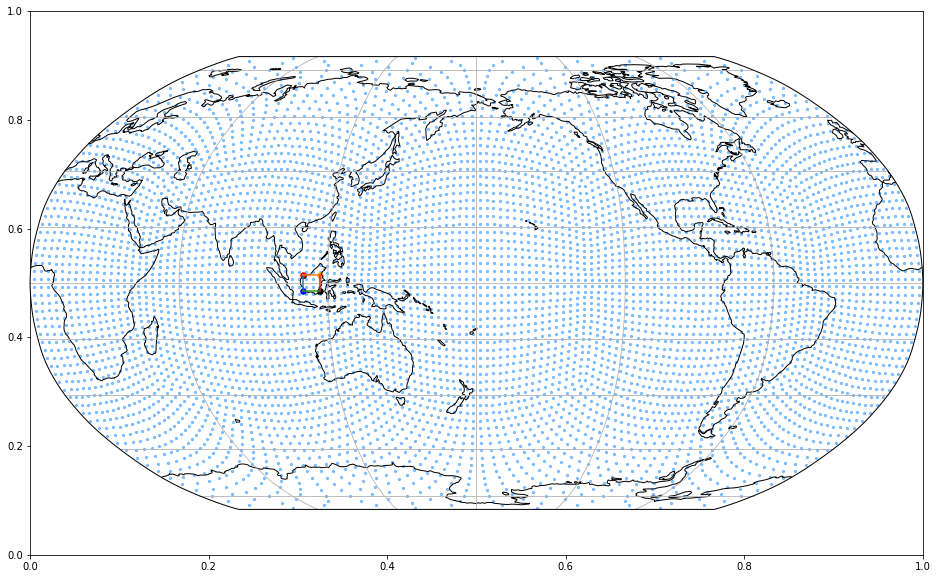

In [20]:
# Check the location of the selected column
#-- create figure and axes object
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax1 = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=180.0))
ax1.set_global()
#-- add coastlines, country border lines, and grid lines
ax1.coastlines()
ax1.gridlines()

plt.scatter(lon[:], lat[:],
            color="dodgerblue",
            s=5,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important

plt.scatter(lon_ERA5[minindexlon1], lat_ERA5[minindexlat1],
    color="red",
    s=30,
    alpha=1,
    transform=ccrs.PlateCarree()) ## Important

plt.scatter(lon_ERA5[minindexlon2], lat_ERA5[minindexlat2],
    color="blue",
    s=30,
    alpha=1,
    transform=ccrs.PlateCarree()) ## Important

plt.scatter(lon_ERA5[minindexlon3], lat_ERA5[minindexlat3],
    color="orange",
    s=30,
    alpha=1,
    transform=ccrs.PlateCarree()) ## Important

plt.scatter(lon_ERA5[minindexlon4], lat_ERA5[minindexlat4],
    color="black",
    s=30,
    alpha=1,
    transform=ccrs.PlateCarree()) ## Important
plt.plot([lon_ERA5[minindexlon1],lon_ERA5[minindexlon2]],[lat_ERA5[minindexlat1],lat_ERA5[minindexlat2]],transform=ccrs.PlateCarree())
plt.plot([lon_ERA5[minindexlon1],lon_ERA5[minindexlon3]],[lat_ERA5[minindexlat1],lat_ERA5[minindexlat3]],transform=ccrs.PlateCarree())
plt.plot([lon_ERA5[minindexlon2],lon_ERA5[minindexlon4]],[lat_ERA5[minindexlat2],lat_ERA5[minindexlat4]],transform=ccrs.PlateCarree())
plt.plot([lon_ERA5[minindexlon3],lon_ERA5[minindexlon4]],[lat_ERA5[minindexlat3],lat_ERA5[minindexlat4]],transform=ccrs.PlateCarree())

plt.savefig('Crosssection_map_SP_UP_Borneo_compare.eps')
plt.show()

In [21]:
# Cloud Fraction
# Read the original 3D data from daily output file
SP_SPWW              = SP2008d.SPWW.values
UP_SPWW              = UP2008d.SPWW.values
SP_CLOUD             = SP2008d.CLOUD.values
UP_CLOUD             = UP2008d.CLOUD.values
SPZ3                 = SP2008d.Z3.values
UPZ3                 = UP2008d.Z3.values
# Calculate the 7-day average
SP_CLOUD_mean    = np.mean(SP_CLOUD[Day_avg_start:Day_avg,:,:], axis=0)
UP_CLOUD_mean    = np.mean(UP_CLOUD[Day_avg_start:Day_avg,:,:], axis=0)
SP_SPWW_mean     = np.mean(SP_SPWW[Day_avg_start:Day_avg,:,:], axis=0)
UP_SPWW_mean     = np.mean(UP_SPWW[Day_avg_start:Day_avg,:,:], axis=0)
SP_Z3_mean       = np.mean(SPZ3[Day_avg_start:Day_avg,:,:], axis=0)
UP_Z3_mean       = np.mean(UPZ3[Day_avg_start:Day_avg,:,:], axis=0)

In [22]:
lon = SP2008d.lon.values
lat = SP2008d.lat.values
points = np.zeros([6144, 2])
points[:,0] = lon
points[:,1] = lat

In [23]:
# interpolate model data to ERA5 grids <This step is slow!!>
SP_CLOUD_meani              = np.zeros([125,721,1440])
UP_CLOUD_meani              = np.zeros([125,721,1440])
SP_SPWW_meani               = np.zeros([125,721,1440])
UP_SPWW_meani               = np.zeros([125,721,1440])
SPZ3_meani                  = np.zeros([125,721,1440])
UPZ3_meani                  = np.zeros([125,721,1440])

xi = lon_ERA5[:]
yi = lat_ERA5[:]
Xi, Yi = np.meshgrid(lon_ERA5, lat_ERA5)
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# I tried to use option linear but it gives many nan
for iz in range(0,125,1):
    SP_CLOUD_meani[iz,:,:]              = griddata(points, SP_CLOUD_mean[iz,:], (Xi, Yi), method='nearest')
    UP_CLOUD_meani[iz,:,:]              = griddata(points, UP_CLOUD_mean[iz,:], (Xi, Yi), method='nearest')
    SP_SPWW_meani[iz,:,:]               = griddata(points, SP_SPWW_mean[iz,:], (Xi, Yi), method='nearest')
    UP_SPWW_meani[iz,:,:]               = griddata(points, UP_SPWW_mean[iz,:], (Xi, Yi), method='nearest')
    SPZ3_meani[iz,:,:]                  = griddata(points, SP_Z3_mean[iz,:], (Xi, Yi), method='nearest')
    UPZ3_meani[iz,:,:]                  = griddata(points, UP_Z3_mean[iz,:], (Xi, Yi), method='nearest')

In [24]:
# Calculate the average.
if minindexlon3>minindexlon2:
    new_count = minindexlon3-minindexlon2+1
else:
    new_count = (1440-minindexlon3)+minindexlon2
    
SP_CLOUD_combine = np.zeros([125,(minindexlat4-minindexlat3),new_count])
UP_CLOUD_combine = np.zeros([125,(minindexlat4-minindexlat3),new_count])
SP_SPWW_combine = np.zeros([125,(minindexlat4-minindexlat3),new_count])
UP_SPWW_combine = np.zeros([125,(minindexlat4-minindexlat3),new_count])
SPZ3_mean_combine = np.zeros([125,(minindexlat4-minindexlat3),new_count])
UPZ3_mean_combine = np.zeros([125,(minindexlat4-minindexlat3),new_count])

for il in range(0,new_count,1):
    if minindexlon3>minindexlon2:
        SP_CLOUD_combine[:,:,il] = SP_CLOUD_meani[:,minindexlat3:minindexlat4,(minindexlon2+il)]
        UP_CLOUD_combine[:,:,il] = UP_CLOUD_meani[:,minindexlat3:minindexlat4,(minindexlon2+il)]
        SP_SPWW_combine[:,:,il] = SP_SPWW_meani[:,minindexlat3:minindexlat4,(minindexlon2+il)]
        UP_SPWW_combine[:,:,il] = UP_SPWW_meani[:,minindexlat3:minindexlat4,(minindexlon2+il)]
        SPZ3_mean_combine[:,:,il] = SPZ3_meani[:,minindexlat3:minindexlat4,(minindexlon2+il)]
        UPZ3_mean_combine[:,:,il] = UPZ3_meani[:,minindexlat3:minindexlat4,(minindexlon2+il)]
    else:
        SP_CLOUD_combine[:,:,il] = SP_CLOUD_meani[:,minindexlat3:minindexlat4,(il-1440+minindexlon3)]
        UP_CLOUD_combine[:,:,il] = UP_CLOUD_meani[:,minindexlat3:minindexlat4,(il-1440+minindexlon3)]
        SP_SPWW_combine[:,:,il] = SP_SPWW_meani[:,minindexlat3:minindexlat4,(il-1440+minindexlon3)]
        UP_SPWW_combine[:,:,il] = UP_SPWW_meani[:,minindexlat3:minindexlat4,(il-1440+minindexlon3)]
        SPZ3_mean_combine[:,:,il] = SPZ3_meani[:,minindexlat3:minindexlat4,(il-1440+minindexlon3)]
        UPZ3_mean_combine[:,:,il] = UPZ3_meani[:,minindexlat3:minindexlat4,(il-1440+minindexlon3)]
        
SP_CLOUD_meani_cross = np.mean(SP_CLOUD_combine, axis=2)
UP_CLOUD_meani_cross = np.mean(UP_CLOUD_combine, axis=2)
SP_SPWW_meani_cross = np.mean(SP_SPWW_combine, axis=2)
UP_SPWW_meani_cross = np.mean(UP_SPWW_combine, axis=2)
SPZ3_meani_cross = np.mean(SPZ3_mean_combine, axis=2)
UPZ3_meani_cross = np.mean(UPZ3_mean_combine, axis=2)


/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


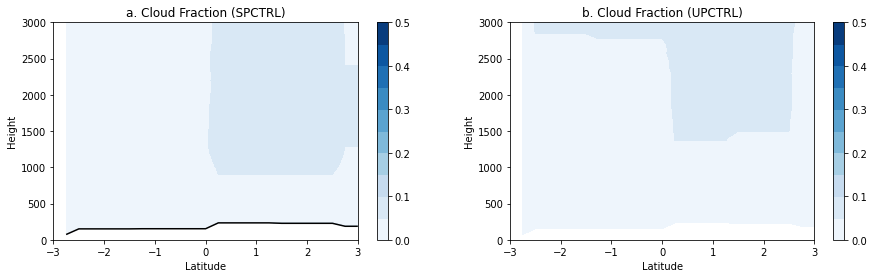

In [25]:
varmin = [0.0]
varmax = [0.5]
varinter = [11]
levels = np.linspace(varmin[0], varmax[0], varinter[0])
yy              = np.linspace(0, 125, 125)
Yi,lat2d        = np.meshgrid(yy,lat_ERA5[minindexlat3:minindexlat4])
lat2d           = np.transpose(lat2d)
xdata = lat2d
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

cf2 = ax2.contourf(xdata,SPZ3_meani_cross,SP_CLOUD_meani_cross,200, cmap="Blues", levels=levels)
cf02 = ax2.contour(xdata,SPZ3_meani_cross,SP_SPWW_meani_cross,200,colors='k', levels=[0.5], linestyles='-')
#cf023 = ax2.contour(xdata,SPZ3_meani_cross,SP_SPWW_meani_cross,200,colors='k', levels=[1.0], linestyles=':')
ax2.set(xlim=(lat_ERA5[minindexlat4], lat_ERA5[minindexlat3]), ylim=(0, 3000))
cb2 = fig.colorbar(cf2, ax=ax2)
titlestring2 = ("a. Cloud Fraction (SPCTRL)")
tx2 = ax2.set_title(titlestring2)
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Height')

cf3 = ax3.contourf(xdata,UPZ3_meani_cross,UP_CLOUD_meani_cross,200, cmap="Blues", levels=levels)
cf03 = ax3.contour(xdata,UPZ3_meani_cross,UP_SPWW_meani_cross,200,colors='k', levels=[0.5], linestyles='-')
cf033 = ax3.contour(xdata,UPZ3_meani_cross,UP_SPWW_meani_cross,200,colors='k', levels=[1.0], linestyles=':')
ax3.set(xlim=(lat_ERA5[minindexlat4], lat_ERA5[minindexlat3]), ylim=(0, 3000))
cb3 = fig.colorbar(cf3, ax=ax3)
titlestring3 = ("b. Cloud Fraction (UPCTRL)")
tx3 = ax3.set_title(titlestring3)
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Height')
plt.savefig('Crosssection_Cloud_SPWW_SP_UP_Borneo.eps')